In [35]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from scipy.spatial import distance

In [37]:
# 1. Load data
weather_df = pd.read_csv(r'D:\SVM\Edit 4 SVM\NYC_Weather_2019.csv')
grid_df = pd.read_csv(r'D:\SVM\Edit 4 SVM\nyc_data_cleaned_normalized [Grid ID + Ride Count].csv')
daily_counts = pd.read_csv(r'D:\SVM\Edit 4 SVM\daily_counts.csv')

In [41]:
# 2. Clean weather data
for col in ['tmpf', 'relh', 'sped', 'p01i', 'vsby']:
    weather_df[col] = pd.to_numeric(weather_df[col], errors='coerce')
weather_df['valid'] = pd.to_datetime(weather_df['valid'], errors='coerce')
weather_df.dropna(subset=['lat', 'lon', 'tmpf', 'relh', 'sped', 'p01i', 'vsby', 'valid'], inplace=True)
weather_df['date'] = weather_df['valid'].dt.date

In [43]:
# 3. Identify weather stations
stations = weather_df.groupby(['lat', 'lon']).size().reset_index()[['lat', 'lon']].to_dict('records')

In [45]:
# 4. Grid setup
for col in ['Min Lat', 'Max Lat', 'Min Long', 'Max Long']:
    grid_df[col] = pd.to_numeric(grid_df[col], errors='coerce')
grid_df.dropna(subset=['Min Lat', 'Max Lat', 'Min Long', 'Max Long'], inplace=True)
grid_df['geometry'] = grid_df.apply(lambda row: box(row['Min Long'], row['Min Lat'], row['Max Long'], row['Max Lat']), axis=1)
grid_df['center_lat'] = (grid_df['Min Lat'] + grid_df['Max Lat']) / 2
grid_df['center_lon'] = (grid_df['Min Long'] + grid_df['Max Long']) / 2

In [47]:
# 5. Assign closest station to each grid

def find_closest_station(lat, lon):
    dists = [distance.euclidean((lat, lon), (s['lat'], s['lon'])) for s in stations]
    return np.argmin(dists)

grid_df['station_idx'] = grid_df.apply(lambda row: find_closest_station(row['center_lat'], row['center_lon']), axis=1)
grid_df['station_lat'] = grid_df['station_idx'].apply(lambda i: stations[i]['lat'])
grid_df['station_lon'] = grid_df['station_idx'].apply(lambda i: stations[i]['lon'])

In [49]:
# 6. Sample weather for each grid
weather_profiles = []
for idx, row in grid_df.iterrows():
    lat, lon = row['station_lat'], row['station_lon']
    station_weather = weather_df[(weather_df['lat'] == lat) & (weather_df['lon'] == lon)]
    sample = station_weather.sample(n=1).iloc[0]
    profile = {
        'Grid ID': row['Grid ID'],
        'date': sample['date'],
        'tmpf': sample['tmpf'],
        'relh': sample['relh'],
        'sped': sample['sped'],
        'p01i': sample['p01i'],
        'vsby': sample['vsby']
    }
    weather_profiles.append(profile)

weather_grid_df = pd.DataFrame(weather_profiles)

In [51]:
# 7. Save weather map
weather_grid_df.to_csv(r'D:\SVM\Edit 4 SVM\weather_map on_Grid.csv', index=False)

In [53]:
# 8. Build weather profile features
def classify_weather(row):
    return 'Good' if (60 <= row['tmpf'] <= 85 and 30 <= row['relh'] <= 60 and row['sped'] <= 15 and row['p01i'] == 0 and row['vsby'] >= 5) else 'Bad'

weather_grid_df['Weather Condition'] = weather_grid_df.apply(classify_weather, axis=1)

In [57]:
# 9. Rename daily_counts to calendar dates
day_cols = [c for c in daily_counts.columns if c.startswith('Day_')]
dates = pd.date_range(start='2019-01-01', periods=len(day_cols)).strftime('%b%d.%Y')
mapping = dict(zip(day_cols, dates))
daily_counts.rename(columns=mapping, inplace=True)
daily_counts.to_csv(r'D:\SVM\Edit 4 SVM\daily_counts_date series.csv', index=False)

In [59]:
# 10. Melt daily_counts to long format
daily_long = daily_counts.melt(id_vars=['Grid ID'], var_name='date', value_name='Ride Count')
daily_long['date'] = pd.to_datetime(daily_long['date'], format='%b%d.%Y').dt.date

In [61]:
# 11. Merge weather and ride data
merged_df = pd.merge(daily_long, weather_grid_df, on=['Grid ID'], how='left')
merged_df.to_csv(r'D:\SVM\Edit 4 SVM\Weather_Grid_Daily-Ride_date series.csv', index=False)

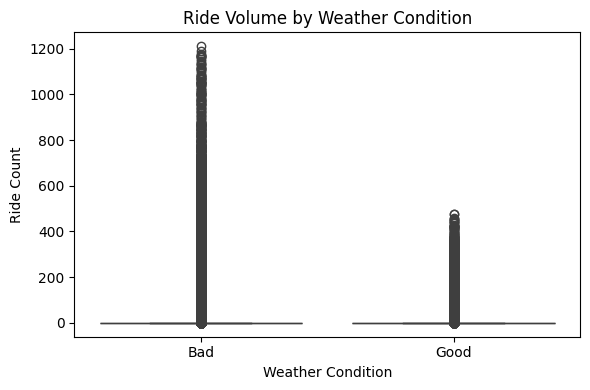

In [63]:
# 12. Visualize ride volume by weather condition
plt.figure(figsize=(6,4))
sns.boxplot(data=merged_df, x='Weather Condition', y='Ride Count')
plt.title('Ride Volume by Weather Condition')
plt.savefig(r'D:\SVM\Edit 4 SVM\ride_volume_by_weather.png')
plt.tight_layout()
plt.show()

In [ ]:
# 13. Train SVM model
